In [1]:
# Quick hack to fix local imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Get Input Datasets

In [2]:
import pyrosm
import geopandas
import numpy as np
import pandas as pd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt, ticker
from shapely.geometry import mapping, box, LineString, Point
from rasterio.crs import CRS

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [3]:
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [4]:
# Get OpenStreetMap data
# fp = pyrosm.get_data("Greater Manchester", update=True)
fp = pyrosm.get_data("Greater London", update=True)

Downloaded Protobuf data 'greater-london-latest.osm.pbf' (65.11 MB) to:
'/tmp/pyrosm/greater-london-latest.osm.pbf'


In [5]:
# Initialize the OSM object 
# osm = pyrosm.OSM(fp)
# Read all boundaries using the default settings
# boundary = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")

# bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf

# bbox = box(-0.161,51.449,-0.002,51.529)  # a random box containing City of London and some of South London like Brixton
bbox = box(-0.417548,51.370878,0.144128,51.602621) # bigger box of London

# bbox = box(-2.387604,53.398281,-2.112259,53.55031)  # Greater Manchester

boundary = geopandas.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

In [6]:
%%time
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326
CPU times: user 3.22 s, sys: 6.38 s, total: 9.59 s
Wall time: 9.65 s


In [7]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [38]:
%%time
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)
residential_buildings = residential_buildings[['building', 'geometry']]

CPU times: user 53 s, sys: 2.11 s, total: 55.1 s
Wall time: 55.1 s


In [39]:
%%time
# crudely get all places that might be considered workplaces
# pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois_filter = {"shop": True,"amenity": True}
pois = osm.get_pois(custom_filter=pois_filter)
office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)
office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

CPU times: user 21.1 s, sys: 1.2 s, total: 22.3 s
Wall time: 22.4 s


In [43]:
%%time
# combine the locations of all of the crude workplaces
trimmed_work = pois[['geometry']].copy()
trimmed_offices = offices[['geometry']]
trimmed_office_buildings = office_buildings[['geometry']]
trimmed_work = trimmed_work.append(trimmed_offices).append(trimmed_office_buildings)
trimmed_work = trimmed_work.reset_index()
orig_crs = trimmed_work.crs
trimmed_work = trimmed_work.to_crs(OUT_CRS) # convert CRS to the final CRS for more correct centroids
trimmed_work['geometry'] = trimmed_work.geometry.convex_hull.centroid  # we use the convex hull because otherwise we get wildly incorrect points for non-convex polygons results
trimmed_work = trimmed_work.to_crs(orig_crs) # convert back for now
# trimmed_work.plot(markersize=0.1)
del trimmed_offices, trimmed_office_buildings, pois

CPU times: user 2.42 s, sys: 31.2 ms, total: 2.45 s
Wall time: 2.46 s


In [44]:
# get all walking networks
# walk_net = osm.get_network(network_type="walking")
# walk_net.plot()

In [45]:
# get all cycling networks
# bike_net = osm.get_network(network_type="cycling")
# bike_net.plot()

In [46]:
# get all road networks
# drive_net = osm.get_network(network_type="driving+service")
# drive_net.plot()

In [47]:
%%time
# get all public transport
edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
nodes = geopandas.GeoDataFrame(nodes, geometry=geopandas.points_from_xy(nodes.lon, nodes.lat), crs="EPSG:4326")
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
clipped_nodes = geopandas.clip(nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = edges[edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(clipped_nodes.set_index(['node', 'layer']).index)]
ori_edges = edges[edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(clipped_nodes.set_index(['node', 'layer']).index)]
edges = des_edges.append(ori_edges)

CPU times: user 3.27 s, sys: 281 ms, total: 3.55 s
Wall time: 3.54 s


In [48]:
%%time
# Draw lines for the edges
old_index = nodes.index
nodes = nodes.set_index(['node', 'layer'])
edges = geopandas.GeoDataFrame(edges, 
                               geometry=edges.apply(lambda x: LineString([nodes.loc[(x.ori_node, x.ori_layer)].geometry, nodes.loc[(x.des_node, x.des_layer)].geometry]), axis=1), 
                               crs="EPSG:4326")
nodes = nodes.reset_index()
nodes.index = old_index

# Clip those edges to the boundary too
clipped_new_edges = geopandas.clip(edges.reset_index(), boundary)

CPU times: user 27.3 s, sys: 46.9 ms, total: 27.3 s
Wall time: 27.3 s


Total Population: 7521401
Buildings from OSM, Residential: 411272, Workplaces: 112410
Public transport graph, nodes: 6850, edges: 33537
CPU times: user 2min 2s, sys: 2.92 s, total: 2min 4s
Wall time: 2min 4s


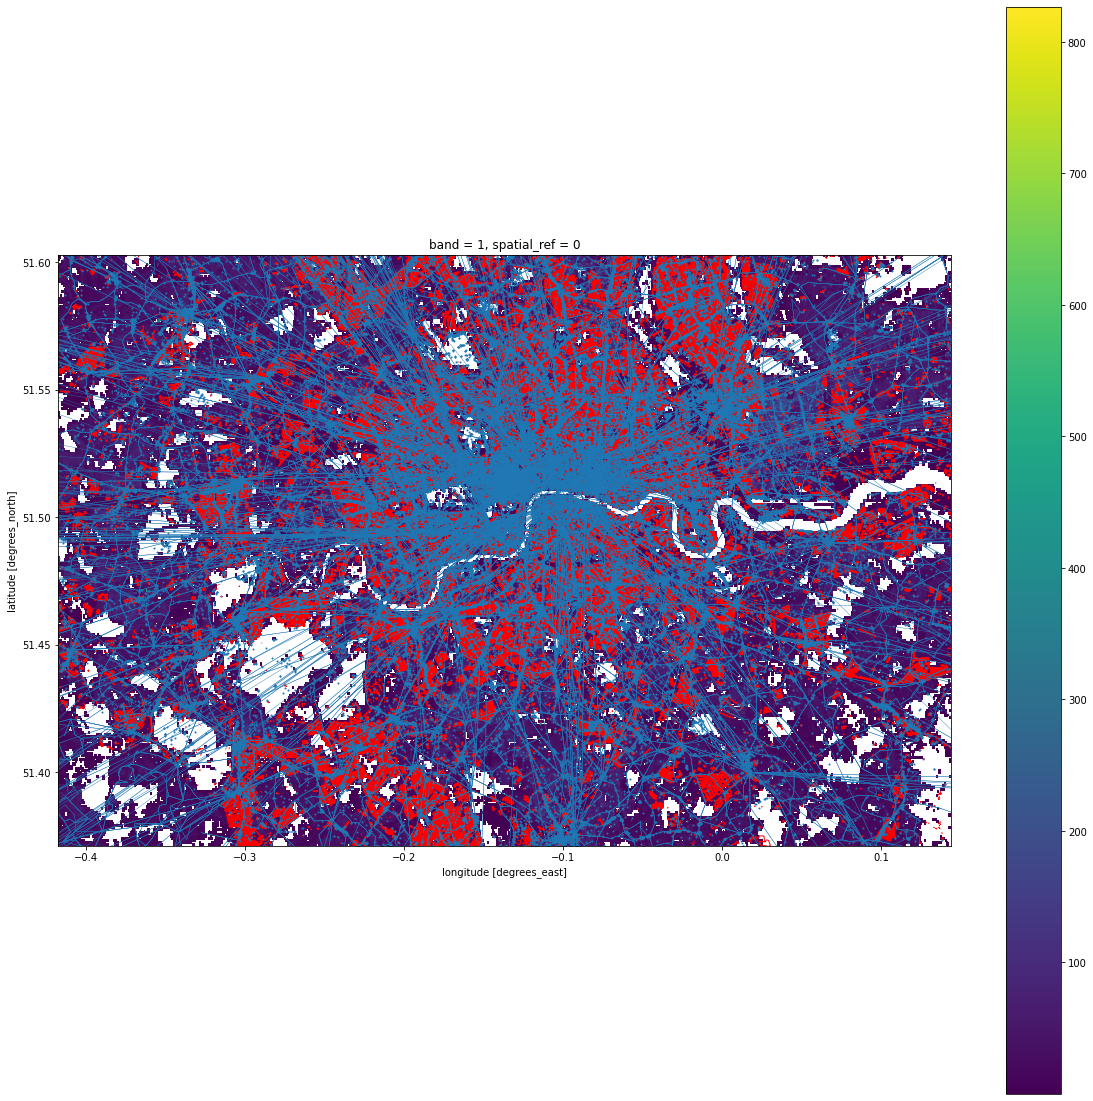

In [49]:
%%time
fig, ax = plt.subplots(figsize=(20, 20))
wp_clipped.plot(ax=ax)
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r')
trimmed_work.plot(ax=ax, markersize=1)
clipped_new_edges[~clipped_new_edges.is_empty].plot(ax=ax, linewidth=0.4)
print(f"Total Population: {int(wp_clipped.sum())}")
print(f"Buildings from OSM, Residential: {len(residential_buildings)}, Workplaces: {len(trimmed_work)}")
print(f"Public transport graph, nodes: {len(clipped_nodes)}, edges: {len(clipped_new_edges)}")
del fig, ax

#### Build Model

In [50]:
import generated.OutbreakSim.Model.Model as gen_model
import generated.OutbreakSim.Model.Agents as gen_agents
import generated.OutbreakSim.Model.Households as gen_households
import generated.OutbreakSim.Model.Vec2 as gen_vec2

import random
from pathlib import Path
from enum import IntEnum
from collections import defaultdict
from typing import Tuple

import flatbuffers

from scipy.spatial import cKDTree
import scipy.stats as stats

from geopy import distance

In [51]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']
    
def convert_to_x_y(in_df):
    out_df = in_df.to_crs(OUT_CRS)
    out_df['x'] = out_df.geometry.centroid.x
    out_df['y'] = out_df.geometry.centroid.y
    out_df['x'] = (out_df['x'] - boundary_minx) / (boundary_maxx - boundary_minx)
    out_df['y'] = (out_df['y'] - boundary_miny) / (boundary_maxy - boundary_miny)
    return out_df[['x', 'y']]

In [52]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [53]:
%%time
nx, ny = wp_clipped.sizes['x'], wp_clipped.sizes['y']
x, y = wp_clipped.rio.transform() * np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5)

# GeoDataFrame of centres of raster cells, indexed by their respective ravelled index
raster_coords = geopandas.GeoDataFrame({'ravelled_index': np.arange(x.size)}, geometry=geopandas.points_from_xy(x.ravel(), y.ravel()), crs="EPSG:4326")
residences_in_radius = cKDQueryRadius(raster_coords, residential_buildings)

CPU times: user 1min 2s, sys: 906 ms, total: 1min 3s
Wall time: 1min 3s


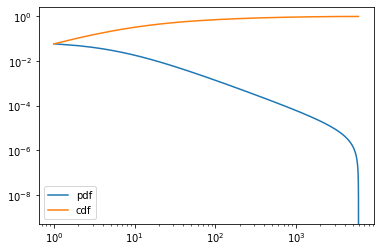

In [54]:
# inspired from Neil Ferguson's
def workplace_size_truncated_power_law(m_max, a, c):
    m = np.arange(1, m_max + 1, dtype='float')
    pmf = (
            (
                    (
                            ((1 + (m_max / a))
                             /
                             (1 + (m / a)))
                            ** c)
                    - 1)
            /
            ((
                    ((1 + (m_max / a)) ** c)
                    - 1)))
    pmf /= pmf.sum()

    return stats.rv_discrete(values=(range(1, m_max + 1), pmf))

max_size = 5920
workplace_size_dist = workplace_size_truncated_power_law(m_max=max_size, a=5.36, c=1.34)

x = np.arange(1, max_size + 1)
fig, ax = plt.subplots()
y_pdf = workplace_size_dist.pmf(x)
y_cdf = workplace_size_dist.cdf(x)
ax.set_xscale(value="log")
ax.set_yscale(value="log")
ax.plot(x, y_pdf, label='pdf')
ax.plot(x, y_cdf, label='cdf')
ax.legend()
del x, fig, ax

In [55]:
%%time
# test that a sampling approach gives a similar graph to that in the papers
counts_per_size = np.zeros(max_size, dtype=np.int32)
N = 10 ** 4
for x in range((10**1) * 2):
    sample = workplace_size_dist.rvs(size=N)
    sizes, counts = np.unique(sample, return_counts=True)
    for size, count in zip(sizes, counts):
        counts_per_size[size] += count

CPU times: user 734 ms, sys: 1.09 s, total: 1.83 s
Wall time: 1.83 s


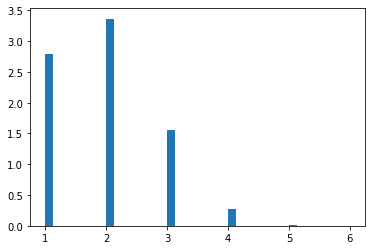

In [56]:
lower, upper = 1, 8
mu, sigma = 2.2, 0.98

household_size_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)  # TODO Replace according to research https://www.statista.com/statistics/281627/households-in-the-united-kingdom-uk-by-size/
fig, ax = plt.subplots(1, 1)
ax.hist(household_size_dist.rvs(100_000).astype(int), density=True, bins=40)
plt.show()
del fig, ax

In [57]:
class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
        

people = []

def add_new_person(household_uid, pos):
    age = random.randint(0, 108)  # Todo update this
    
    new_person = Person(uid=len(people), household_uid=household_uid, age=age, pos=pos)
    people.append(new_person)
    
    return new_person

In [58]:
class Household():
    def __init__(self, uid, max_inhabitants, pos: Tuple[float, float]):
        self.uid = uid
        self.inhabitants = 0
        self.max_inhabitants = max_inhabitants
        self.pos = pos
    
    def to_dict(self):
        return {
            'uid': self.uid,
            'inhabitants': self.inhabitants,
            'max_inhabitants': self.max_inhabitants,
            'pos': self.pos,
        }
    
households = []

def add_new_household(pos_geometry):
    max_inhabitants = household_size_dist.rvs(1)[0]
    
    new_household = Household(uid=len(households), max_inhabitants=max_inhabitants, pos=pos_geometry)
    households.append(new_household)
    
    return new_household

In [59]:
class ResidenceType(IntEnum):
    HOUSE = 0
    SMALL_FLATS = 1  # Perhaps a few floors or flats in one building
    LARGE_FLATS = 2  # Generally high-rise, shared lifts, etc.


residence_params = {
    'max_household_capacity': 7,
    ResidenceType.HOUSE: {
        'max_households': 2
    },
    ResidenceType.SMALL_FLATS: {
        'max_households': 10
    },
    ResidenceType.LARGE_FLATS: {
        'max_households': 150
    }
}

residential_buildings['residence_type'] = ResidenceType.HOUSE
residential_buildings.loc[residential_buildings['building'].isin(['apartments', 'flats']), 'residence_type'] = ResidenceType.SMALL_FLATS
residential_buildings.drop('building', axis='columns', inplace=True)

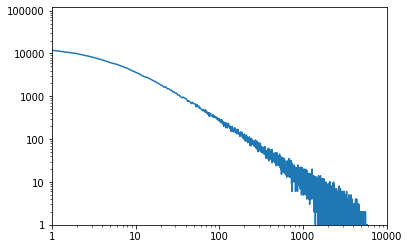

In [60]:
fig, ax = plt.subplots()
ax.set_xscale(value="log")
ax.set_yscale(value="log")
ax.plot(list(range(0, max_size)), counts_per_size)
ax.set_xlim([1, 10**4])
ax.set_ylim([1, np.max(counts_per_size) * 10])
scalar_formatter = ticker.ScalarFormatter()
scalar_formatter.set_powerlimits((0, 9))
ax.get_xaxis().set_major_formatter(scalar_formatter)
ax.get_yaxis().set_major_formatter(scalar_formatter)

del N, counts_per_size

### Household Allocation and Person Generation

In [61]:
%%time
# NOTE: Seems to grow roughly linearly with population
residences_to_households = defaultdict(lambda: [])
residential_buildings = residential_buildings.to_crs(OUT_CRS)

# reset lists
households = []
people = []
failures = 0

for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        index = (row, col)
        people_at_tile = wp_clipped[row, col]
        
        if np.isnan(people_at_tile):
            continue
        
        local_residences_indices = residences_in_radius.loc[np.ravel_multi_index(index, wp_clipped.shape), 'Elements in Radius']
        
        for _ in range(int(people_at_tile)):
            shuffled_indices = np.random.permutation(local_residences_indices)

            chosen_household = None

            for residence_index in shuffled_indices:
                households_at_residence = [households[household_uid] for household_uid in residences_to_households[residence_index]]
                possible_households = [household for household in households_at_residence if household.inhabitants < household.max_inhabitants]

                if len(possible_households) != 0:
                    chosen_household = random.choice(possible_households)
                    chosen_household.inhabitants += 1
                    break
                else:
                    building_type = residential_buildings.loc[residence_index, 'residence_type']
                    
                    if len(households_at_residence) < residence_params[building_type]['max_households']:
                        pos = residential_buildings.loc[residence_index].geometry.centroid
                        pos = (pos.x, pos.y)
                        chosen_household = add_new_household(pos)
                        residences_to_households[residence_index].append(chosen_household.uid)
                        
                        chosen_household.inhabitants += 1
                        
            else:  # failed to find an available household, or residence to make a new household in, so upgrade a residence 
                smaller_residences_indices = [residence_index for residence_index in local_residences_indices 
                                              if residential_buildings.loc[residence_index, 'residence_type'] != ResidenceType.LARGE_FLATS]
                
                if len(smaller_residences_indices) != 0:
                    chosen_residence_index = random.choice(smaller_residences_indices)
                    residential_buildings.loc[chosen_residence_index, 'residence_type'] = ResidenceType(residential_buildings.loc[chosen_residence_index, 'residence_type'] + 1)
                    
                    pos = residential_buildings.loc[chosen_residence_index].geometry.centroid
                    pos = (pos.x, pos.y)
                    chosen_household = add_new_household(pos)
                    residences_to_households[chosen_residence_index].append(chosen_household.uid)
                else:
                        failures += 1
                        continue
#                     raise Exception("Bugger gotta deal with this")
            add_new_person(chosen_household.uid, chosen_household.pos)    
print(f"Failures: {failures}/{int(wp_clipped.sum())}, Failure Rate: {failures/int(wp_clipped.sum()):.2f}")

Failures: 852158/7521401, Failure Rate: 0.11
CPU times: user 1h 38min 37s, sys: 2min 40s, total: 1h 41min 18s
Wall time: 1h 41min 20s


### Workplace Allocation

In [62]:
trimmed_work['capacity'] = workplace_size_dist.rvs(size=len(trimmed_work))
trimmed_work

,index,geometry,capacity
0,0,POINT (-0.15282 51.52436),26
1,1,POINT (-0.13551 51.52356),11
2,2,POINT (-0.09339 51.52913),4
3,3,POINT (-0.14312 51.52826),116
4,4,POINT (-0.14028 51.53426),68
...,...,...,...
112405,999,POINT (-0.12897 51.50051),2564
112406,1000,POINT (-0.12914 51.49785),129
112407,1001,POINT (-0.12243 51.56643),38
112408,1002,POINT (-0.18367 51.47826),3


In [ ]:
# %%time
# households_df = pd.DataFrame.from_records([h.to_dict() for h in households])
# households_gdf = geopandas.GeoDataFrame(households_df, geometry=households_df['pos'].apply(lambda x: Point(x[0], x[1])), crs=OUT_CRS)
# households_gdf.drop(['pos', 'max_inhabitants'], axis=1, inplace=True)

In [63]:
import pickle
from pathlib import Path
# Path('pickles/greater_manchester/households_gdf').write_bytes(pickle.dumps(households_gdf))
Path('pickles/london/people_list').write_bytes(pickle.dumps(people))
Path('pickles/london/workplaces_gdf').write_bytes(pickle.dumps(trimmed_work))
Path('pickles/london/boundary').write_bytes(pickle.dumps(boundary))

968

In [ ]:
%%time
households_gdf.plot(markersize=0.1)

In [ ]:
%%time
# uses over 15gb of memory
# workplaces_in_radius = cKDQueryRadius(households_gdf, trimmed_work, radius=20_000, p=np.inf, workers=6)

In [ ]:
print(len(households))
print(len(people))

In [ ]:
for household in households:
    household.pos = (((household.pos.x - boundary_minx) / (boundary_maxx - boundary_minx)), 
                     ((household.pos.y - boundary_miny) / (boundary_maxy - boundary_miny)))

In [ ]:
X = [household.pos[0] for household in households]
Y = [household.pos[1] for household in households]

plt.scatter(X, Y, markersize=0.2)

del X, Y

In [ ]:
# TODO, nonsense atm
AGENT_SIZE = 32  # in bytes
WORKPLACE_SIZE = 8  # in bytes
HOUSEHOLD_SIZE = 8  # in bytes
CONTAINER_SIZE = 8  # in bytes

initial_buffer_size = (int(wp_clipped.sum())
                       * AGENT_SIZE + len(residential_buildings) 
                       * HOUSEHOLD_SIZE + len(trimmed_work) 
                       * WORKPLACE_SIZE)
print(initial_buffer_size)

In [ ]:
builder = flatbuffers.Builder(initial_buffer_size)

In [ ]:
# Create `vectors` representing the attributes of the Agents SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
gen_agents.AgentsStartAgeVector(builder, len(people))
for i in reversed(range(0, len(people))):
    builder.PrependUint8(people[i].age)
agents_age_vec = builder.EndVector(len(people))

gen_agents.AgentsStartHouseholdIndexVector(builder, len(people))
for i in reversed(range(0, len(people))):
    builder.PrependUint32(people[i].household_uid)
agents_household_index_vec = builder.EndVector(len(people))

# gen.Model.Agents.AgentsStartWorkplaceIndexVector(builder, len(people))
# for i in reversed(range(0, len(people))):
#     builder.PrependUint32(people[i].workplace_uid)
# agents_workplace_index_vec = builder.EndVector(len(people))

gen_agents.AgentsStart(builder)
gen_agents.AgentsAddAge(builder, agents_age_vec)
gen_agents.AgentsAddHouseholdIndex(builder, agents_household_index_vec)
# gen.Agents.AgentsAddWorkplaceIndex(builder, agents_workplace_index_vec)
built_agents = gen_agents.AgentsEnd(builder)

In [ ]:
# Create `vectors` representing the attributes of the Households SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
gen_households.HouseholdsStartPosVector(builder, len(households))
for i in reversed(range(0, len(households))):
    gen_vec2.CreateVec2(builder, households[i].pos[0], households[i].pos[1])
households_pos_vec = builder.EndVector(len(households))

gen_households.HouseholdsStart(builder)
gen_households.HouseholdsAddPos(builder, households_pos_vec)
built_households = gen_households.HouseholdsEnd(builder)

In [ ]:
# Create Model
gen_model.ModelStart(builder)
gen_model.ModelAddAgents(builder, built_agents)
gen_model.ModelAddHouseholds(builder, built_households)
built_model = gen_model.ModelEnd(builder)
builder.Finish(built_model)
buf = builder.Output()

In [ ]:
out_path = Path("./output/model_mid_south_london_1m.txt")
out_path.write_bytes(buf)